In [1]:
import anndata as ad
from collections import Counter
from itertools import combinations
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scanpy as sc
from scipy.stats import kruskal, mannwhitneyu, false_discovery_control
import seaborn as sns

import sys
sys.path.append('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/libraries/')
from clinical import load_clinical
from data_processing import *
from spatial import *

In [2]:
adata = ad.read_h5ad('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/hdf5_codex_final_stromal_phenotypes_inc_unclassifiable.h5ad')

/mnt/cephfs/home/users/krakovic/.conda/envs/scpy/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
adata.var_names

Index(['CD105_z', 'CD31_z', 'FAP_z', 'CD20_z', 'CD68_z', 'CD38_z', 'CD45_z',
       'Podoplanin_z', 'GATA6_z', 'HLA-DR_z', 'COL1A_z', 'CA9_z', 'CD8_z',
       'SMA_z', 'DECORIN_z', 'ECAD_z', 'CD4_z', 'GREM1_z', 'COLIV_z', 'NCAD_z',
       'CKPAN_z', 'LIF_z', 'S100A4_z', 'Vimentin_z', 'IL6_z', 'HNF4A_z'],
      dtype='object')

In [3]:
adata_df = sc.get.obs_df(adata=adata, keys=['CellX', 'CellY', 'TMA', 'core_ID', 'samples', 'concat_phenotype', 'text_phenotype', 'final_phenotype'])
adata_df['final_phenotype'] = adata_df['final_phenotype'].fillna('Unclassifiable')
adata_df

CellX    CellY TMA  core_ID   samples         concat_phenotype  \
0         2396.8   6263.1  12  12-15-J  ACA_0662               Stroma_nan   
1         2420.0   6264.4  12  12-15-J  ACA_0662                   Tumour   
2         2428.9   6265.5  12  12-15-J  ACA_0662                   Tumour   
3         2409.4   6267.8  12  12-15-J  ACA_0662                   Tumour   
4         2474.5   6266.5  12  12-15-J  ACA_0662  Negative/unclassifiable   
...          ...      ...  ..      ...       ...                      ...   
2670918  17607.6  20332.7  22  22-15-J  ACA_1069        Immune_CD45+ CD4+   
2670919  17733.6  20460.9  22  22-15-J  ACA_1069       Immune_CD45+ CD20+   
2670920  17500.8  20961.7  22  22-15-J  ACA_1069                 Stroma_4   
2670921  17685.7  20402.6  22  22-15-J  ACA_1069       Immune_CD45+ CD20+   
2670922  17706.2  20425.7  22  22-15-J  ACA_1069       Immune_CD45+ CD20+   

                  text_phenotype          final_phenotype  
0                            NaN           Unclassifiable  
1                            NaN                   Tumour  
2                            NaN                   Tumour  
3                            NaN                   Tumour  
4                            NaN           Unclassifiable  
...                          ...                      ...  
2670918                      NaN                     CD4+  
2670919                      NaN                    CD20+  
2670920  $DCN_{high}COL1A_{med}$  $DCN_{high}COL1A_{med}$  
2670921                      NaN                    CD20+  
2670922                      NaN                    CD20+  

[2670923 rows x 8 columns]

In [ ]:
# From /nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/HPC_distribution_codex.ipynb
pure_clusters_frame = pd.read_csv('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/codex_pure_superclusters_split_HPC13.csv', index_col=0)
pure_clusters_frame = pure_clusters_frame.replace({'cold_cohesive':'Cold, cohesive', 'cold_discohesive':'Cold, discohesive', 'hot_cohesive':'Hot, cohesive', 'hot_discohesive':'Hot, discohesive'})
pure_clusters_frame

core_ID       supercluster cluster  consensus_HD_equal  consensus_HD_more
0    12-02-A  Cold, discohesive  HPC 27                   1                  0
1    12-02-B      Hot, cohesive   HPC 0                   1                  0
2    12-02-C      Hot, cohesive  HPC 67                   1                  0
3    12-02-D   Hot, discohesive  HPC 10                   0                  0
4    12-02-F     Cold, cohesive     NaN                   1                  0
..       ...                ...     ...                 ...                ...
221  22-14-A  Cold, discohesive  HPC 31                   1                  0
222  22-14-G     Cold, cohesive  HPC 68                   1                  0
223  22-14-H   Hot, discohesive  HPC 28                   0                  0
224  22-15-A      Hot, cohesive  HPC 50                   1                  0
225  22-15-I      Hot, cohesive  HPC 50                   1                  0

[226 rows x 5 columns]

In [ ]:
pure_clusters_frame['supercluster'].value_counts()

Hot, discohesive     65
Cold, cohesive       59
Cold, discohesive    51
Hot, cohesive        51
Name: supercluster, dtype: int64

In [ ]:
pure_cores_to_exclude = [
    '12-04-F', '12-05-B', '12-05-C', '12-09-C', '12-13-A',
    '13-06-J', '13-09-G', '13-10-D'
    '21-02-F', '21-04-B', '21-04-F', '21-09-C',
    '22-15-G'
]

other_cores_to_exclude = [
    '12-02-E', '12-02-J', '12-05-B', '12-09-C', '12-10-C', '12-11-C', '12-14-A',
    '13-05-F', '13-06-C', '13-07-J', '13-07-G', '13-10-A', '13-15-C',
    '21-02-B', '21-02-G', '21-03-G', '21-13-H', '21-13-J', '21-14-A', '21-14-H', '21-15-A', '21-15-E', '21-15-H',
    '22-02-A', '22-02-C', '22-02-I', '22-03-A', '22-03-B', '22-03-F', '22-04-A', '22-04-F', '22-05-F', '22-6-E', '22-09-C', '22-10-C', '22-13-I', '23-15-A', '22-15-C', '22-15-F', '22-15-G'
]

all_cores_to_exclude = pure_cores_to_exclude + other_cores_to_exclude

In [7]:
pure_clusters_frame[~pure_clusters_frame['core_ID'].isin(all_cores_to_exclude)]['supercluster'].value_counts()

Hot, discohesive     59
Cold, cohesive       56
Hot, cohesive        47
Cold, discohesive    45
Name: supercluster, dtype: int64

In [8]:
pure_clusters_frame[(~pure_clusters_frame['core_ID'].isin(all_cores_to_exclude)) & (pure_clusters_frame['supercluster'] == "Hot, discohesive")]['consensus_HD_more'].value_counts()

0    52
1     7
Name: consensus_HD_more, dtype: int64

In [9]:
adata_df = adata_df[~adata_df['core_ID'].isin(all_cores_to_exclude)]

In [10]:
adata_df['core_ID'].nunique()

392

### Identify discohesive cells

In [11]:
from sklearn.cluster import DBSCAN

def get_core_noise_prop(core_df, x_col, y_col, phenotype_col, phenotype, eps, min_samples):
    points = core_df[core_df[phenotype_col] == phenotype][[x_col, y_col]].values

    clusters = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=10).fit_predict(points)
    total_cells = clusters.shape[0]
    noise_cells = clusters[clusters == -1].shape[0]
    prop_noise = noise_cells / total_cells

    # Reassign labels -- merge all clusters (comparison is cohesive vs not)
    clusters[clusters != -1] = 1

    return clusters, prop_noise

# get_core_noise_prop(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='cell_lineage', phenotype='CKPAN+', eps=15, min_samples=5)

In [12]:
adata_df

CellX    CellY TMA  core_ID   samples         concat_phenotype  \
0         2396.8   6263.1  12  12-15-J  ACA_0662               Stroma_nan   
1         2420.0   6264.4  12  12-15-J  ACA_0662                   Tumour   
2         2428.9   6265.5  12  12-15-J  ACA_0662                   Tumour   
3         2409.4   6267.8  12  12-15-J  ACA_0662                   Tumour   
4         2474.5   6266.5  12  12-15-J  ACA_0662  Negative/unclassifiable   
...          ...      ...  ..      ...       ...                      ...   
2670918  17607.6  20332.7  22  22-15-J  ACA_1069        Immune_CD45+ CD4+   
2670919  17733.6  20460.9  22  22-15-J  ACA_1069       Immune_CD45+ CD20+   
2670920  17500.8  20961.7  22  22-15-J  ACA_1069                 Stroma_4   
2670921  17685.7  20402.6  22  22-15-J  ACA_1069       Immune_CD45+ CD20+   
2670922  17706.2  20425.7  22  22-15-J  ACA_1069       Immune_CD45+ CD20+   

                  text_phenotype          final_phenotype  
0                            NaN           Unclassifiable  
1                            NaN                   Tumour  
2                            NaN                   Tumour  
3                            NaN                   Tumour  
4                            NaN           Unclassifiable  
...                          ...                      ...  
2670918                      NaN                     CD4+  
2670919                      NaN                    CD20+  
2670920  $DCN_{high}COL1A_{med}$  $DCN_{high}COL1A_{med}$  
2670921                      NaN                    CD20+  
2670922                      NaN                    CD20+  

[2444292 rows x 8 columns]

In [13]:
cores = adata_df['core_ID'].unique()
noise_list = list()

for i, core in enumerate(cores):
    core_idx = adata_df.loc[(adata_df['core_ID'] == core) & (adata_df['final_phenotype'] == 'Tumour')].index.values
    clusters, noise = get_core_noise_prop(core_df=adata_df[adata_df['core_ID'] == core], x_col='CellX', y_col='CellY', phenotype_col='final_phenotype', phenotype='Tumour', eps=25, min_samples=5)
    adata_df.loc[core_idx, 'dbscan'] = clusters
    noise_list.append((core, noise))
    

/tmp/ipykernel_1405753/2792439964.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_df.loc[core_idx, 'dbscan'] = clusters


In [ ]:
pure_clusters_frame[pure_clusters_frame['core_ID'].isin(cores)]['supercluster'].value_counts()

Hot, discohesive     58
Cold, cohesive       53
Cold, discohesive    44
Hot, cohesive        44
Name: supercluster, dtype: int64

In [ ]:
pure_clusters_frame[(pure_clusters_frame['core_ID'].isin(cores)) & (pure_clusters_frame['supercluster'] == "Hot, discohesive")]['consensus_HD_more'].value_counts()

0    51
1     7
Name: consensus_HD_more, dtype: int64

In [16]:
noise_df = pd.DataFrame(noise_list, columns=['core_ID', 'noise'])
noise_df = noise_df.merge(pure_clusters_frame[['core_ID', 'cluster', 'supercluster']], on='core_ID', how='inner')
noise_df

core_ID     noise cluster       supercluster
0    12-15-I  0.673267     NaN   Hot, discohesive
1    12-15-G  0.038313  HPC 44      Hot, cohesive
2    12-15-F  0.958678     NaN  Cold, discohesive
3    12-15-E  0.454768     NaN  Cold, discohesive
4    12-14-I  0.103106     NaN  Cold, discohesive
..       ...       ...     ...                ...
194  22-14-A  0.262976  HPC 31  Cold, discohesive
195  22-14-G  0.037216  HPC 68     Cold, cohesive
196  22-14-H  0.900000  HPC 28   Hot, discohesive
197  22-15-A  0.028233  HPC 50      Hot, cohesive
198  22-15-I  0.854015  HPC 50      Hot, cohesive

[199 rows x 4 columns]

/tmp/ipykernel_1405753/4115437685.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


Text(0.5, 0, 'Supercluster')

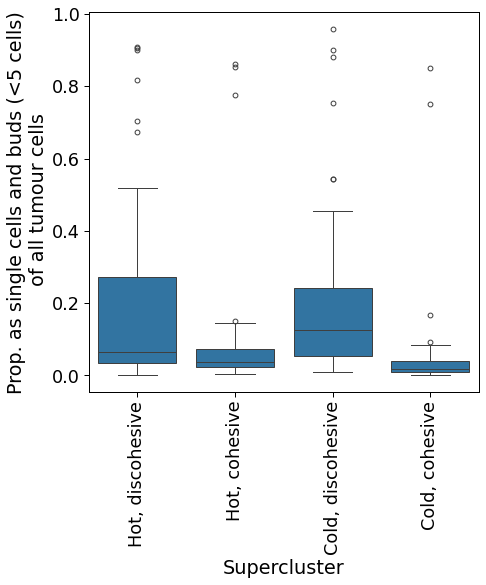

In [17]:
# Ensure superclusters behave as they should when running DBSCAN on a separate dataset
# Expected behaviour: discohesive groups are highest for discohesion again and this is what we see

sns.set_context("paper", font_scale=2.0)
fig, ax = plt.subplots(figsize=(7,7))

sns.boxplot(data=noise_df, x='supercluster', y='noise', ax=ax)
# sns.barplot(data=noise_df, x='supercluster', y='noise', ax=ax, estimator='mean', errorbar='ci')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_ylabel('Prop. as single cells and buds (<5 cells)\n of all tumour cells')
ax.set_xlabel('Supercluster')

In [18]:
## Alter the phenotypes of tumour cells -- split these into cohesive and discohesive based on DBSCAN results

## Helper function to implement logic

def assign_cohesive_phenotype(row):
    if row['final_phenotype'] != 'Tumour':
        return row['final_phenotype']
    else:
        if row['dbscan'] == -1:
            return 'Discohesive tumour'
        else:
            return 'Cohesive tumour'

adata_df['disco_phenotype'] = adata_df.apply(lambda row: assign_cohesive_phenotype(row), axis=1)

/tmp/ipykernel_1405753/3540594315.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata_df['disco_phenotype'] = adata_df.apply(lambda row: assign_cohesive_phenotype(row), axis=1)


### Neighbourhood analysis

In [19]:
def neighbourhood_frequency_vector(neighbourhood_phenotypes, all_phenotypes=None):
    if all_phenotypes is None:
        all_phenotypes = set()
        for centroid in neighbourhood_phenotypes:
            all_phenotypes.update(centroid)
    else:
        all_phenotypes = set(all_phenotypes)

    results = list()

    for idx, phenotypes in enumerate(neighbourhood_phenotypes):
        counts = Counter(phenotypes)

        idx_dict = {
            'index':idx,
            'Total_Cells':phenotypes.shape[0]
        }

        for phenotype in all_phenotypes:
            idx_dict[f'{phenotype}'] = counts.get(phenotype, 0)

        results.append(idx_dict)
    
    results_df = pd.DataFrame(results)

    return results_df

def cell_nearest_neighbours(core_df, x_col, y_col, phenotype_col, radius, all_phenotypes=None, k=12, buffer_distance=50):
    coordinates = core_df[[x_col, y_col]].values
    phenotypes = core_df[phenotype_col].values
    idx = core_df.index

    if buffer_distance > 0:
        interior_mask = create_buffer(coordinates, buffer_distance)
        coordinates = coordinates[interior_mask]
        phenotypes = phenotypes[interior_mask]
        idx = idx[interior_mask]

    tree = KDTree(coordinates)
    neighbours = tree.query_ball_point(coordinates, r=radius, workers=k)

    neighbourhood_phenotypes = [phenotypes[res] for res in neighbours]

    results_df = neighbourhood_frequency_vector(neighbourhood_phenotypes=neighbourhood_phenotypes, all_phenotypes=all_phenotypes)
    results_df['orig_idx'] = idx
    results_df['orig_phenotype'] = phenotypes

    return results_df

def enrichment_test_by_phenotype(data, phenotype_cols, meta_col, p_th=0.05):
    results = list()
    overall_avg = data.mean(numeric_only=True, axis=0)
    for group in data[meta_col].unique():
        for phenotype in phenotype_cols:
            positive_group = data[data[meta_col] == group][phenotype].values
            # negative_group = data[data[meta_col] != group][phenotype].values
            negative_group = data[phenotype].values
            statistic, p_value = mannwhitneyu(positive_group, negative_group, alternative='two-sided')
            # relative_change = (np.mean(positive_group) - np.mean(negative_group)) / (abs(np.mean(negative_group)) + 0.001)
            # relative_change = (np.mean(positive_group) - np.mean(negative_group)) / (abs(np.mean(negative_group)) + 0.001)
            log_fc = np.log2((np.mean(positive_group) + 1e-9) / (overall_avg.loc[phenotype] + 1e-9))


            results.append({
                'Supercluster':group,
                'marker':phenotype,
                'l2fc':log_fc,
                'statistic':statistic,
                'p_val': p_value
            })

    results = pd.DataFrame(results)
    results['p_adj'] = false_discovery_control(results['p_val'], method='bh')
    change_data = results.pivot(index='Supercluster', columns='marker', values='l2fc')
    pval_data = results.pivot(index='Supercluster', columns='marker', values='p_adj')

    significant_mask = pval_data < p_th
    annot_text = change_data.applymap('{:.2f}'.format)
    annot_text = annot_text.mask(significant_mask, '*')
    annot_text = annot_text.mask(~significant_mask, ' ')

    return change_data, annot_text

In [20]:
pure_cores_list = list(core for core in pure_clusters_frame['core_ID'].values if core in adata.obs['core_ID'].unique())
pure_cores_list = [core for core in pure_cores_list if core not in all_cores_to_exclude]

all_phenotypes = adata_df['disco_phenotype'].unique()
nn_list = list()

for core in pure_cores_list:
    core_df = adata_df[adata_df['core_ID'] == core]
    nn_df = cell_nearest_neighbours(core_df=core_df, x_col='CellX', y_col='CellY', phenotype_col='disco_phenotype', radius=25, all_phenotypes=all_phenotypes)
    nn_df['core'] = core
    nn_list.append(nn_df)

neighbourhood_df = pd.concat(nn_list)
neighbourhood_df

index  Total_Cells  $SMA_{high}LIF_{high}$  Discohesive tumour  \
0         0            5                       0                   0   
1         1           10                       0                   0   
2         2            7                       0                   0   
3         3           11                       0                   0   
4         4            2                       0                   0   
...     ...          ...                     ...                 ...   
4808   4808           13                       0                   0   
4809   4809           18                       0                   1   
4810   4810           15                       0                   2   
4811   4811           20                       0                   0   
4812   4812           17                       0                   0   

      Endothelium  CD4+  Unclassifiable  $SMA_{med}COL1A_{med}$  \
0               0     0               1                       0   
1               0     0               0                       0   
2               0     0               0                       1   
3               0     0               0                       1   
4               0     0               1                       0   
...           ...   ...             ...                     ...   
4808            1     0              11                       0   
4809            0     0              11                       0   
4810            0     0               8                       0   
4811            2     0              13                       0   
4812            0     0              16                       0   

      $DCN_{high}COL1A_{med}$  Cohesive tumour  $PDPN_{high}$  \
0                           0                4              0   
1                           0               10              0   
2                           0                6              0   
3                           0               10              0   
4                           0                1              0   
...                       ...              ...            ...   
4808                        0                0              0   
4809                        0                0              0   
4810                        0                0              0   
4811                        0                0              0   
4812                        0                0              0   

      $COL1A_{high}DCN_{med}$  CD68+  CD8+  CD20+  $S100A4_{high}FAP_{high}$  \
0                           0      0     0      0                          0   
1                           0      0     0      0                          0   
2                           0      0     0      0                          0   
3                           0      0     0      0                          0   
4                           0      0     0      0                          0   
...                       ...    ...   ...    ...                        ...   
4808                        0      0     0      1                          0   
4809                        0      1     4      1                          0   
4810                        0      1     3      1                          0   
4811                        0      1     2      0                          2   
4812                        0      1     0      0                          0   

     orig_idx   orig_phenotype     core  
0      566379   Unclassifiable  12-02-A  
1      566380  Cohesive tumour  12-02-A  
2      566381  Cohesive tumour  12-02-A  
3      566382  Cohesive tumour  12-02-A  
4      566383   Unclassifiable  12-02-A  
...       ...              ...      ...  
4808  2660221            CD20+  22-15-I  
4809  2660222   Unclassifiable  22-15-I  
4810  2660223             CD8+  22-15-I  
4811  2660224   Unclassifiable  22-15-I  
4812  2660225   Unclassifiable  22-15-I  

[1183873 rows x 19 columns]

In [21]:
neighbourhood_df

index  Total_Cells  $SMA_{high}LIF_{high}$  Discohesive tumour  \
0         0            5                       0                   0   
1         1           10                       0                   0   
2         2            7                       0                   0   
3         3           11                       0                   0   
4         4            2                       0                   0   
...     ...          ...                     ...                 ...   
4808   4808           13                       0                   0   
4809   4809           18                       0                   1   
4810   4810           15                       0                   2   
4811   4811           20                       0                   0   
4812   4812           17                       0                   0   

      Endothelium  CD4+  Unclassifiable  $SMA_{med}COL1A_{med}$  \
0               0     0               1                       0   
1               0     0               0                       0   
2               0     0               0                       1   
3               0     0               0                       1   
4               0     0               1                       0   
...           ...   ...             ...                     ...   
4808            1     0              11                       0   
4809            0     0              11                       0   
4810            0     0               8                       0   
4811            2     0              13                       0   
4812            0     0              16                       0   

      $DCN_{high}COL1A_{med}$  Cohesive tumour  $PDPN_{high}$  \
0                           0                4              0   
1                           0               10              0   
2                           0                6              0   
3                           0               10              0   
4                           0                1              0   
...                       ...              ...            ...   
4808                        0                0              0   
4809                        0                0              0   
4810                        0                0              0   
4811                        0                0              0   
4812                        0                0              0   

      $COL1A_{high}DCN_{med}$  CD68+  CD8+  CD20+  $S100A4_{high}FAP_{high}$  \
0                           0      0     0      0                          0   
1                           0      0     0      0                          0   
2                           0      0     0      0                          0   
3                           0      0     0      0                          0   
4                           0      0     0      0                          0   
...                       ...    ...   ...    ...                        ...   
4808                        0      0     0      1                          0   
4809                        0      1     4      1                          0   
4810                        0      1     3      1                          0   
4811                        0      1     2      0                          2   
4812                        0      1     0      0                          0   

     orig_idx   orig_phenotype     core  
0      566379   Unclassifiable  12-02-A  
1      566380  Cohesive tumour  12-02-A  
2      566381  Cohesive tumour  12-02-A  
3      566382  Cohesive tumour  12-02-A  
4      566383   Unclassifiable  12-02-A  
...       ...              ...      ...  
4808  2660221            CD20+  22-15-I  
4809  2660222   Unclassifiable  22-15-I  
4810  2660223             CD8+  22-15-I  
4811  2660224   Unclassifiable  22-15-I  
4812  2660225   Unclassifiable  22-15-I  

[1183873 rows x 19 columns]

In [22]:
from sklearn.cluster import MiniBatchKMeans
counts_cols = [col for col in neighbourhood_df.columns if col not in ['x', 'y', 'index', 'Total_Cells', 'core', 'km_cluster', 'orig_idx', 'orig_phenotype']]

# wcss = list()

# for i in range(6, 16, 2):
#         kmeans = MiniBatchKMeans(n_clusters=i, random_state=0)
#         kmeans.fit(neighbourhood_df[counts_cols].values)
#         wcss.append(kmeans.inertia_)

# sns.set_context("paper", font_scale=2.0)
# fig, ax = plt.subplots(figsize=(12,5))

# ax.plot(range(6, 16, 2), wcss)

In [23]:
n_clusters = 12
km = MiniBatchKMeans(n_clusters=n_clusters, random_state=0)
labels_km = km.fit_predict(neighbourhood_df[counts_cols].values)

neighbourhood_df['km_cluster'] = labels_km
neighbourhood_df

index  Total_Cells  $SMA_{high}LIF_{high}$  Discohesive tumour  \
0         0            5                       0                   0   
1         1           10                       0                   0   
2         2            7                       0                   0   
3         3           11                       0                   0   
4         4            2                       0                   0   
...     ...          ...                     ...                 ...   
4808   4808           13                       0                   0   
4809   4809           18                       0                   1   
4810   4810           15                       0                   2   
4811   4811           20                       0                   0   
4812   4812           17                       0                   0   

      Endothelium  CD4+  Unclassifiable  $SMA_{med}COL1A_{med}$  \
0               0     0               1                       0   
1               0     0               0                       0   
2               0     0               0                       1   
3               0     0               0                       1   
4               0     0               1                       0   
...           ...   ...             ...                     ...   
4808            1     0              11                       0   
4809            0     0              11                       0   
4810            0     0               8                       0   
4811            2     0              13                       0   
4812            0     0              16                       0   

      $DCN_{high}COL1A_{med}$  Cohesive tumour  $PDPN_{high}$  \
0                           0                4              0   
1                           0               10              0   
2                           0                6              0   
3                           0               10              0   
4                           0                1              0   
...                       ...              ...            ...   
4808                        0                0              0   
4809                        0                0              0   
4810                        0                0              0   
4811                        0                0              0   
4812                        0                0              0   

      $COL1A_{high}DCN_{med}$  CD68+  CD8+  CD20+  $S100A4_{high}FAP_{high}$  \
0                           0      0     0      0                          0   
1                           0      0     0      0                          0   
2                           0      0     0      0                          0   
3                           0      0     0      0                          0   
4                           0      0     0      0                          0   
...                       ...    ...   ...    ...                        ...   
4808                        0      0     0      1                          0   
4809                        0      1     4      1                          0   
4810                        0      1     3      1                          0   
4811                        0      1     2      0                          2   
4812                        0      1     0      0                          0   

     orig_idx   orig_phenotype     core  km_cluster  
0      566379   Unclassifiable  12-02-A           7  
1      566380  Cohesive tumour  12-02-A           1  
2      566381  Cohesive tumour  12-02-A           1  
3      566382  Cohesive tumour  12-02-A           1  
4      566383   Unclassifiable  12-02-A           7  
...       ...              ...      ...         ...  
4808  2660221            CD20+  22-15-I           2  
4809  2660222   Unclassifiable  22-15-I           2  
4810  2660223             CD8+  22-15-I           2  
4811  2660224   Unclassifiable  22-15-I           4  


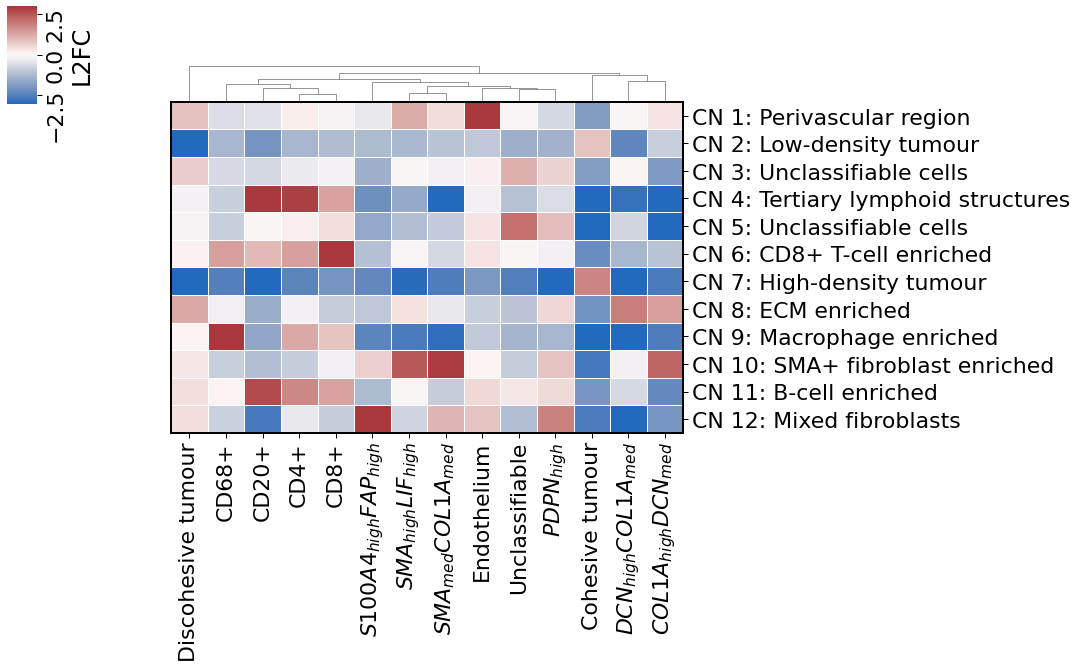

In [24]:
from matplotlib.patches import Rectangle
import matplotlib as mpl

mpl.rcParams['pdf.fonttype'] = 42

log_fc_df = pd.DataFrame(columns=counts_cols)
overall_avg = neighbourhood_df[counts_cols].mean(axis=0)
for cluster in range(n_clusters):
    cluster_means = neighbourhood_df[neighbourhood_df['km_cluster'] == cluster][counts_cols].mean(axis=0)
    log_fc = np.log2((cluster_means + 1e-9) / (overall_avg + 1e-9))
    log_fc_df.loc[cluster] = log_fc

log_fc_df.index = [f"CN {i}" for i in log_fc_df.index]

# log_fc_df.index = [
#     "CN 1: Low-density tumour",
#     "CN 2: Mixed lymphocytes",
#     "CN 3: DCN/COL1A enriched",
#     "CN 4: Unclassifiable cells",
#     "CN 5: Macrophage enriched",
#     "CN 6: Desmoplasia",
#     "CN 7: Tertiary lymphoid structures",
#     "CN 8: High-density tumour"
# ]

log_fc_df.index = [
    "CN 1: Perivascular region",
    "CN 2: Low-density tumour",
    "CN 3: Unclassifiable cells" ,
    "CN 4: Tertiary lymphoid structures",
    "CN 5: Unclassifiable cells",
    "CN 6: CD8+ T-cell enriched ",
    "CN 7: High-density tumour",
    "CN 8: ECM enriched",
    "CN 9: Macrophage enriched",
    "CN 10: SMA+ fibroblast enriched",
    "CN 11: B-cell enriched",
    "CN 12: Mixed fibroblasts"
]

sns.set_context("paper", font_scale=2.5)

g = sns.clustermap(data=log_fc_df,
                   cmap='vlag',
                   linewidth=.5,
                   vmin=-3, vmax=3,
                   row_cluster=False,
                   dendrogram_ratio=(.1, .1), 
                   cbar_pos=(-0.08, 0.9, 0.03, 0.15), 
                   cbar_kws={'label': 'L2FC'},
                   figsize=(14,9))

n_rows, n_cols = log_fc_df.shape
g.ax_heatmap.collections[0].set_linewidth(.5)
rect = Rectangle(
    xy=(0, 0),  # Lower left corner
    width=n_cols,
    height=n_rows,
    fill=False,
    edgecolor='black',
    linewidth=2,
    clip_on=False
)

g.ax_heatmap.add_patch(rect)
g.cax.tick_params(labelrotation=90)


plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);

plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/250408_cn_disco_logfc_k12_rot_cbar_ticklabs.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/250408_cn_disco_logfc_k12_rot_cbar_ticklabs.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)


In [25]:
counts_list = dict()

for core in neighbourhood_df['core'].unique():
    subset = neighbourhood_df[neighbourhood_df['core'] == core]
    counts = subset['km_cluster'].value_counts()
    counts_list[core] = counts

cn_frequency_df = pd.DataFrame.from_dict(counts_list, orient='index').fillna(0).reset_index().rename(columns={'index':'core_ID'})
cn_frequency_df = cn_frequency_df.merge(pure_clusters_frame[['core_ID', 'supercluster']], left_on='core_ID', right_on='core_ID')

cn_frequency_df = cn_frequency_df.rename(columns={0:"CN 1: Perivascular region",
                                                  1:"CN 2: Low-density tumour",
                                                  2:"CN 3: Unclassifiable cells",
                                                  3:"CN 4: Tertiary lymphoid structures",
                                                  4:"CN 5: Unclassifiable cells",
                                                  5:"CN 6: CD8+ T-cell enriched",
                                                  6:"CN 7: High-density tumour",
                                                  7:"CN 8: ECM enriched",
                                                  8:"CN 9: Macrophage enriched",
                                                  9:"CN 10: SMA+ fibroblast enriched",
                                                  10:"CN 11: B-cell enriched",
                                                  11:"CN 12: Mixed fibroblasts"})


cn_log_fc_df, annot_text = enrichment_test_by_phenotype(data=cn_frequency_df, phenotype_cols=[col for col in cn_frequency_df.columns if 'CN' in col], meta_col='supercluster')
cn_log_fc_df.columns.name = None
cn_log_fc_df.index.name = None

cn_proportion_df = cn_frequency_df[cn_log_fc_df.columns].apply(lambda row: row / np.sum(row), axis=1)
cn_proportion_df['core_ID'] = cn_frequency_df['core_ID']
cn_proportion_df['supercluster'] = cn_frequency_df['supercluster']

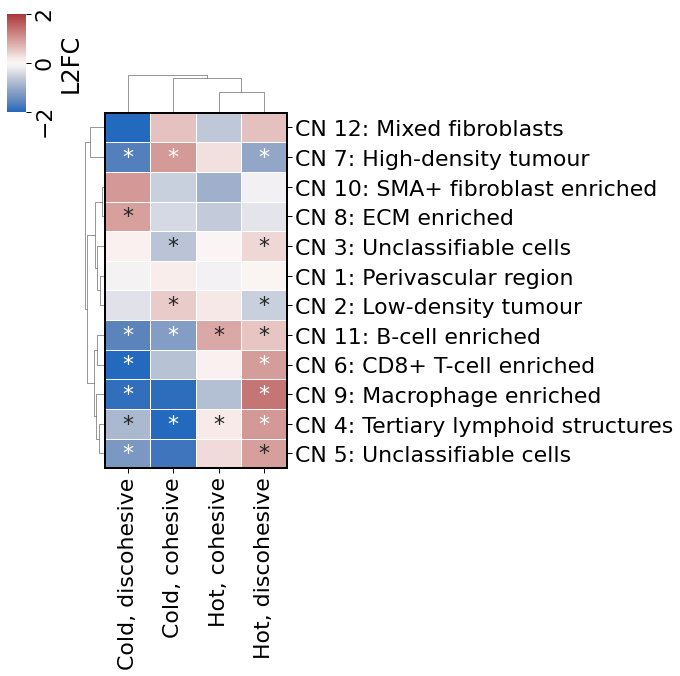

In [26]:
cn_prop_log_fc_df, annot_text = enrichment_test_by_phenotype(data=cn_proportion_df, phenotype_cols=[col for col in cn_frequency_df.columns if 'CN' in col], meta_col='supercluster', p_th=0.05)
cn_prop_log_fc_df.columns.name = None
cn_prop_log_fc_df.index.name = None

# cn_prop_log_fc_df.columns = [
#     "CN 1: Low-density tumour",
#     "CN 2: Mixed lymphocytes",
#     "CN 3: DCN/COL1A enriched",
#     "CN 4: Unclassifiable cells",
#     "CN 5: Macrophage enriched",
#     "CN 6: Desmoplasia",
#     "CN 7: Tertiary lymphoid structures",
#     "CN 8: High-density tumour"
# ]

# cn_prop_log_fc_df.index = [
#     'Cold\ncohesive',
#     'Cold\ndiscohesive',
#     'Hot\ncohesive',
#     'Hot\ndiscohesive'

# ]

g = sns.clustermap(data=cn_prop_log_fc_df.T,
               cmap='vlag',
               linewidth=.5,
               vmin=-2, vmax=2,
               annot=annot_text.T,
               fmt='',
               annot_kws={'fontsize':22},
               dendrogram_ratio=(.1, .1), 
               cbar_pos=(-0.08, 0.9, 0.03, 0.15), 
               cbar_kws={'label': 'L2FC'},
               figsize=(8.9,9))

n_rows, n_cols = cn_prop_log_fc_df.T.shape
g.ax_heatmap.collections[0].set_linewidth(.5)

rect = Rectangle(
    xy=(0, 0),  # Lower left corner
    width=n_cols,
    height=n_rows,
    fill=False,
    edgecolor='black',
    linewidth=2,
    clip_on=False
)

g.ax_heatmap.add_patch(rect)
g.cax.tick_params(labelrotation=90)

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);

# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/cell/plots/with_unclassifiable_cells/250314_cn_prop_enrichment_sc_disco.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/250408_cn_disco_prop_enrichment_k12_rot_cbar_labs.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/250408_cn_disco_prop_enrichment_k12_rot_cbar_labs.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)



### Deconvolve Hot discohesive?

In [27]:
cn_prop_log_fc_df

CN 10: SMA+ fibroblast enriched  CN 11: B-cell enriched  \
Cold, cohesive                           -0.547215               -1.230019   
Cold, discohesive                         0.998614               -1.598048   
Hot, cohesive                            -0.953161                0.816099   
Hot, discohesive                         -0.155088                0.541243   

                   CN 12: Mixed fibroblasts  CN 1: Perivascular region  \
Cold, cohesive                     0.571790                   0.155355   
Cold, discohesive                 -3.131409                  -0.118213   
Hot, cohesive                     -0.641530                  -0.133712   
Hot, discohesive                   0.584895                   0.032719   

                   CN 2: Low-density tumour  CN 3: Unclassifiable cells  \
Cold, cohesive                     0.479121                   -0.688837   
Cold, discohesive                 -0.321897                    0.107613   
Hot, cohesive                      0.191183                    0.008196   
Hot, discohesive                  -0.547348                    0.360471   

                   CN 4: Tertiary lymphoid structures  \
Cold, cohesive                              -2.555983   
Cold, discohesive                           -0.834174   
Hot, cohesive                                0.186072   
Hot, discohesive                             0.990648   

                   CN 5: Unclassifiable cells  CN 6: CD8+ T-cell enriched  \
Cold, cohesive                      -1.821754                   -0.732639   
Cold, discohesive                   -1.299901                   -2.438777   
Hot, cohesive                        0.326324                    0.093879   
Hot, discohesive                     0.936031                    0.949770   

                   CN 7: High-density tumour  CN 8: ECM enriched  \
Cold, cohesive                      0.979252           -0.427891   
Cold, discohesive                  -1.666626            0.917776   
Hot, cohesive                       0.273619           -0.601170   
Hot, discohesive                   -1.078446           -0.288973   

                   CN 9: Macrophage enriched  
Cold, cohesive                     -1.952788  
Cold, discohesive                  -1.919222  
Hot, cohesive                      -0.760412  
Hot, discohesive                    1.348558

In [28]:
pure_clusters_frame

core_ID       supercluster cluster  consensus_HD_equal  consensus_HD_more
0    12-02-A  Cold, discohesive  HPC 27                   1                  0
1    12-02-B      Hot, cohesive   HPC 0                   1                  0
2    12-02-C      Hot, cohesive  HPC 67                   1                  0
3    12-02-D   Hot, discohesive  HPC 10                   0                  0
4    12-02-F     Cold, cohesive     NaN                   1                  0
..       ...                ...     ...                 ...                ...
221  22-14-A  Cold, discohesive  HPC 31                   1                  0
222  22-14-G     Cold, cohesive  HPC 68                   1                  0
223  22-14-H   Hot, discohesive  HPC 28                   0                  0
224  22-15-A      Hot, cohesive  HPC 50                   1                  0
225  22-15-I      Hot, cohesive  HPC 50                   1                  0

[226 rows x 5 columns]

In [29]:
def assign_cohesive_phenotype(row):
    if row['supercluster'] != 'Hot, discohesive':
        return row['supercluster']
    else:
        if row['consensus_HD_equal'] == 1:
            return 'Hot, discohesive (high risk)'
        else:
            return 'Hot, discohesive (low risk)'

pure_clusters_frame['cons_supercluster'] = pure_clusters_frame.apply(lambda row: assign_cohesive_phenotype(row), axis=1)
pure_clusters_frame

core_ID       supercluster cluster  consensus_HD_equal  \
0    12-02-A  Cold, discohesive  HPC 27                   1   
1    12-02-B      Hot, cohesive   HPC 0                   1   
2    12-02-C      Hot, cohesive  HPC 67                   1   
3    12-02-D   Hot, discohesive  HPC 10                   0   
4    12-02-F     Cold, cohesive     NaN                   1   
..       ...                ...     ...                 ...   
221  22-14-A  Cold, discohesive  HPC 31                   1   
222  22-14-G     Cold, cohesive  HPC 68                   1   
223  22-14-H   Hot, discohesive  HPC 28                   0   
224  22-15-A      Hot, cohesive  HPC 50                   1   
225  22-15-I      Hot, cohesive  HPC 50                   1   

     consensus_HD_more            cons_supercluster  
0                    0            Cold, discohesive  
1                    0                Hot, cohesive  
2                    0                Hot, cohesive  
3                    0  Hot, discohesive (low risk)  
4                    0               Cold, cohesive  
..                 ...                          ...  
221                  0            Cold, discohesive  
222                  0               Cold, cohesive  
223                  0  Hot, discohesive (low risk)  
224                  0                Hot, cohesive  
225                  0                Hot, cohesive  

[226 rows x 6 columns]

In [30]:
cn_proportion_df_ = cn_proportion_df.merge(pure_clusters_frame[['core_ID', 'cluster', 'cons_supercluster']], how='left')
cn_proportion_df_

CN 10: SMA+ fibroblast enriched  CN 11: B-cell enriched  \
0                           0.035567                0.000000   
1                           0.000000                0.007272   
2                           0.000676                0.016565   
3                           0.065211                0.000000   
4                           0.010047                0.251465   
..                               ...                     ...   
194                         0.009570                0.000000   
195                         0.011750                0.000000   
196                         0.000208                0.003324   
197                         0.000000                0.002460   
198                         0.000000                0.000000   

     CN 12: Mixed fibroblasts  CN 1: Perivascular region  \
0                    0.000000                   0.006506   
1                    0.000000                   0.001505   
2                    0.000000                   0.012170   
3                    0.633748                   0.024725   
4                    0.000000                   0.044376   
..                        ...                        ...   
194                  0.000000                   0.111017   
195                  0.011750                   0.007554   
196                  0.000000                   0.018907   
197                  0.000000                   0.030996   
198                  0.000000                   0.008906   

     CN 2: Low-density tumour  CN 3: Unclassifiable cells  \
0                    0.627846                    0.001735   
1                    0.503260                    0.201354   
2                    0.516903                    0.008114   
3                    0.112637                    0.000434   
4                    0.167318                    0.118755   
..                        ...                         ...   
194                  0.536368                    0.083581   
195                  0.628619                    0.008393   
196                  0.002493                    0.702265   
197                  0.000000                    0.432718   
198                  0.000000                    0.015058   

     CN 4: Tertiary lymphoid structures  CN 5: Unclassifiable cells  \
0                              0.000000                    0.000000   
1                              0.000000                    0.019057   
2                              0.000000                    0.000000   
3                              0.000000                    0.000000   
4                              0.224951                    0.015769   
..                                  ...                         ...   
194                            0.000000                    0.000425   
195                            0.000000                    0.000000   
196                            0.000000                    0.183669   
197                            0.000000                    0.481427   
198                            0.000000                    0.001377   

     CN 6: CD8+ T-cell enriched  CN 7: High-density tumour  \
0                      0.000434                   0.145738   
1                      0.000502                   0.170512   
2                      0.028398                   0.164638   
3                      0.000000                   0.033112   
4                      0.000419                   0.034608   
..                          ...                        ...   
194                    0.000000                   0.061251   
195                    0.000420                   0.209820   
196                    0.010596                   0.000000   
197                    0.000000                   0.000000   
198                    0.269121                   0.000000   

     CN 8: ECM enriched  CN 9: Macrophage enriched  core_ID  \
0              0.182173                   0.000000  12-02-A   
1              0.092026                   0.004514  12-02-

In [31]:
cn_proportion_df_['cons_supercluster'].value_counts()

Cold, cohesive                  53
Hot, discohesive (low risk)     50
Cold, discohesive               44
Hot, cohesive                   44
Hot, discohesive (high risk)     8
Name: cons_supercluster, dtype: int64

In [32]:
cn_proportion_df_[cn_proportion_df_['cons_supercluster'] == 'Hot, discohesive (high risk)']

CN 10: SMA+ fibroblast enriched  CN 11: B-cell enriched  \
7                           0.045839                0.000000   
23                          0.001202                0.000240   
34                          0.008912                0.080351   
41                          0.001635                0.000490   
42                          0.063955                0.000000   
155                         0.001131                0.002263   
176                         0.031752                0.017584   
183                         0.006634                0.008600   

     CN 12: Mixed fibroblasts  CN 1: Perivascular region  \
7                    0.464963                   0.012587   
23                   0.000000                   0.012740   
34                   0.000000                   0.020512   
41                   0.000000                   0.002288   
42                   0.000000                   0.010711   
155                  0.000000                   0.026589   
176                  0.000000                   0.051107   
183                  0.000000                   0.074324   

     CN 2: Low-density tumour  CN 3: Unclassifiable cells  \
7                    0.284050                    0.006575   
23                   0.709135                    0.013942   
34                   0.020229                    0.458481   
41                   0.483164                    0.338673   
42                   0.485563                    0.218410   
155                  0.678861                    0.055817   
176                  0.523846                    0.006199   
183                  0.364251                    0.252211   

     CN 4: Tertiary lymphoid structures  CN 5: Unclassifiable cells  \
7                              0.000000                    0.000000   
23                             0.000000                    0.000000   
34                             0.108785                    0.146555   
41                             0.000000                    0.006048   
42                             0.000000                    0.010866   
155                            0.000000                    0.000000   
176                            0.000127                    0.000506   
183                            0.000000                    0.046192   

     CN 6: CD8+ T-cell enriched  CN 7: High-density tumour  \
7                      0.000000                   0.017283   
23                     0.023077                   0.022356   
34                     0.059839                   0.001698   
41                     0.002942                   0.040209   
42                     0.000000                   0.104160   
155                    0.016594                   0.016594   
176                    0.001392                   0.029855   
183                    0.000614                   0.101966   

     CN 8: ECM enriched  CN 9: Macrophage enriched  core_ID      supercluster  \
7              0.168702                   0.000000  12-03-D  Hot, discohesive   
23             0.217308                   0.000000  12-09-E  Hot, discohesive   
34             0.093931                   0.000707  12-11-F  Hot, discohesive   
41             0.124551                   0.000000  12-14-C  Hot, discohesive   
42             0.106333                   0.000000  12-14-G  Hot, discohesive   
155            0.187252                   0.014897  22-03-D  Hot, discohesive   
176            0.197217                   0.140417  22-07-H  Hot, discohesive   
183            0.072850                   0.072359  22-10-F  Hot, discohesive   

    cluster             cons_supercluster  
7    HPC 13  Hot, discohesive (high risk)  
23   HPC 13  Hot, discohesive (high risk)  
34      NaN  Hot, discohesive (high risk)  
41   HPC 13  Hot, discohesive (high risk)  
42   HPC 13  Hot, discohesive (high risk)  
155  HPC 13  Hot, discohesive (high risk)  
176  HPC 13  Hot, discohesive (high risk)  
183  HPC 13  Hot, discohesive (high risk)

In [33]:
cn_prop_log_fc_df.index

Index(['Cold, cohesive', 'Cold, discohesive', 'Hot, cohesive',
       'Hot, discohesive'],
      dtype='object')

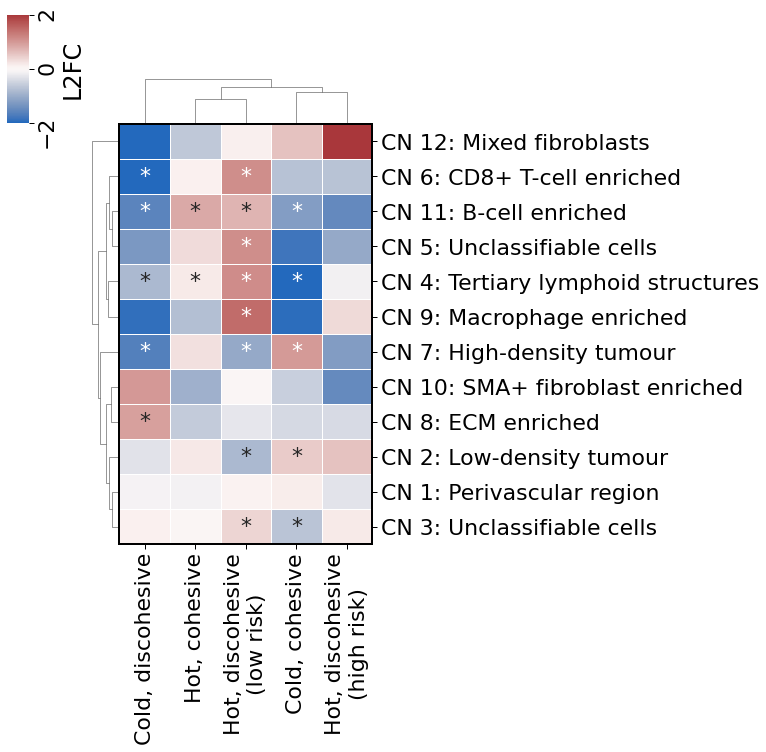

In [34]:
cn_prop_log_fc_df, annot_text = enrichment_test_by_phenotype(data=cn_proportion_df_, phenotype_cols=[col for col in cn_frequency_df.columns if 'CN' in col], meta_col='cons_supercluster', p_th=0.05)
cn_prop_log_fc_df.columns.name = None
cn_prop_log_fc_df.index.name = None

# cn_prop_log_fc_df.columns = [
#     "CN 1: Low-density tumour",
#     "CN 2: Mixed lymphocytes",
#     "CN 3: DCN/COL1A enriched",
#     "CN 4: Unclassifiable cells",
#     "CN 5: Macrophage enriched",
#     "CN 6: Desmoplasia",
#     "CN 7: Tertiary lymphoid structures",
#     "CN 8: High-density tumour"
# ]

cn_prop_log_fc_df.index = ['Cold, cohesive', 
                           'Cold, discohesive', 
                           'Hot, cohesive',
                           'Hot, discohesive\n(high risk)', 
                           'Hot, discohesive\n(low risk)']

g = sns.clustermap(data=cn_prop_log_fc_df.T,
               cmap='vlag',
               linewidth=.5,
               vmin=-2, vmax=2,
               annot=annot_text.T,
               fmt='',
               annot_kws={'fontsize':22},
               dendrogram_ratio=(.1, .1), 
               cbar_pos=(-0.08, 0.9, 0.03, 0.15), 
               cbar_kws={'label': 'L2FC'},
               figsize=(10.,10))

n_rows, n_cols = cn_prop_log_fc_df.T.shape
g.ax_heatmap.collections[0].set_linewidth(.5)

rect = Rectangle(
    xy=(0, 0),  # Lower left corner
    width=n_cols,
    height=n_rows,
    fill=False,
    edgecolor='black',
    linewidth=2,
    clip_on=False
)

g.ax_heatmap.add_patch(rect)

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);
g.cax.tick_params(labelrotation=90)

plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/250408_cn_disco_prop_enrichment_split_HPC13_k12_rot_cbar_labs.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)
# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/250408_cn_disco_prop_enrichment_split_HPC13_k12_rot_cbar_labs.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)


In [49]:
cn_proportion_df_hd = cn_proportion_df_[cn_proportion_df_['supercluster'] == 'Hot, discohesive']
cn_proportion_df_hd

CN 10: SMA+ fibroblast enriched  \
3                           0.065211   
7                           0.045839   
19                          0.051705   
20                          0.005127   
23                          0.001202   
28                          0.014230   
30                          0.062205   
34                          0.008912   
40                          0.000000   
41                          0.001635   
42                          0.063955   
47                          0.016044   
52                          0.032300   
57                          0.010237   
59                          0.003366   
62                          0.026197   
72                          0.043687   
76                          0.055344   
82                          0.448082   
87                          0.045704   
88                          0.566988   
89                          0.031697   
94                          0.002569   
95                          0.008745   
97                          0.016893   
98                          0.013548   
109                         0.064430   
111                         0.016269   
118                         0.029887   
123                         0.002654   
126                         0.412869   
129                         0.030374   
131                         0.070641   
134                         0.001041   
140                         0.001324   
146                         0.001867   
150                         0.000594   
155                         0.001131   
157                         0.004961   
158                         0.001444   
160                         0.004230   
162                         0.009803   
165                         0.016544   
168                         0.078050   
176                         0.031752   
178                         0.000308   
180                         0.000097   
181                         0.001113   
182                         0.073758   
183                         0.006634   
185                         0.055928   
187                         0.000000   
188                         0.353704   
189                         0.000690   
191                         0.066716   
192                         0.004458   
197                         0.000000   
198                         0.000000   

     CN 11: CD20+ B-cell enriched inflammation  CN 12: Mixed fibroblasts  \
3                                     0.000000                  0.633748   
7                                     0.000000                  0.464963   
19                                    0.007976                  0.000000   
20                                    0.161286                  0.000000   
23                                    0.000240                  0.000000   
28                                    0.113425                  0.000000   
30                                    0.025059                  0.000147   
34                                    0.080351                  0.000000   
40                                    0.191089                  0.000000   
41                                    0.000490                  0.000000   
42                                    0.000000                  0.000000   
47                                    0.011400                  0.000000   
52                                    0.058967                  0.000000   
57                                    0.000000                  0.023886   
59                                    0.010097                  0.000000   
62                                    0.001041                  0.000000   
72                                    0.073586                  0.000000   
76                                    0.000000                  0.000000   
82                                    0.001737                  0.007751   
87                                    0.116880                  0.010725   
88                                    0.000000  

In [50]:
def enrichment_test_by_phenotype_two_sample(data, phenotype_cols, meta_col, p_th=0.05):
    results = list()
    overall_avg = data.mean(numeric_only=True, axis=0)
    for group in data[meta_col].unique():
        for phenotype in phenotype_cols:
            positive_group = data[data[meta_col] == group][phenotype].values
            negative_group = data[data[meta_col] != group][phenotype].values
            # negative_group = data[phenotype].values
            statistic, p_value = mannwhitneyu(positive_group, negative_group, alternative='two-sided')
            # relative_change = (np.mean(positive_group) - np.mean(negative_group)) / (abs(np.mean(negative_group)) + 0.001)
            # relative_change = (np.mean(positive_group) - np.mean(negative_group)) / (abs(np.mean(negative_group)) + 0.001)
            log_fc = np.log2((np.mean(positive_group) + 1e-9) / (np.mean(negative_group) + 1e-9))
            # log_fc = np.log2((np.mean(positive_group) + 1e-9) / (overall_avg.loc[phenotype] + 1e-9))


            results.append({
                'Supercluster':group,
                'marker':phenotype,
                'l2fc':log_fc,
                'statistic':statistic,
                'p_val': p_value
            })

    results = pd.DataFrame(results)
    results['p_adj'] = false_discovery_control(results['p_val'], method='bh')
    change_data = results.pivot(index='Supercluster', columns='marker', values='l2fc')
    pval_data = results.pivot(index='Supercluster', columns='marker', values='p_adj')

    significant_mask = pval_data < p_th
    annot_text = change_data.applymap('{:.2f}'.format)
    annot_text = annot_text.mask(significant_mask, '*')
    annot_text = annot_text.mask(~significant_mask, ' ')

    return change_data, annot_text

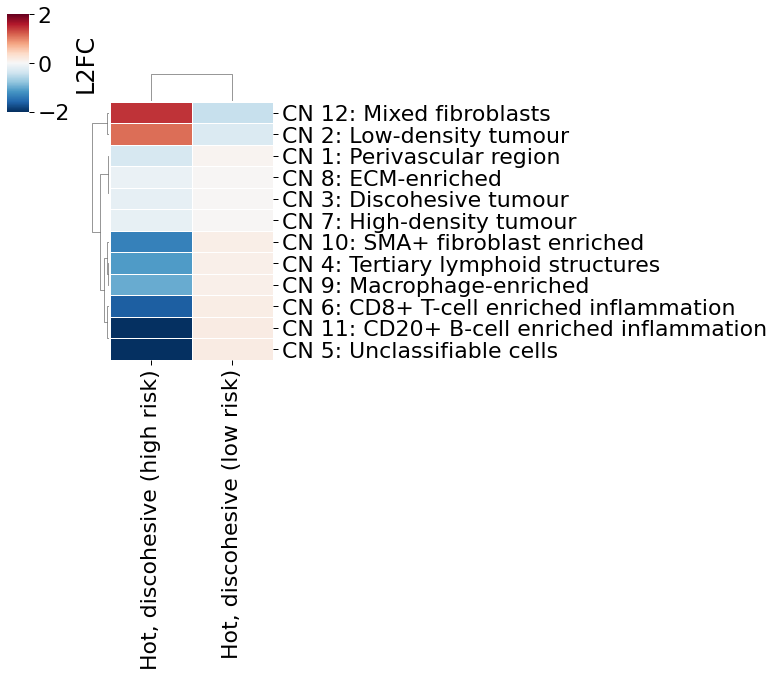

In [51]:
cn_prop_log_fc_df, annot_text = enrichment_test_by_phenotype(data=cn_proportion_df_hd, phenotype_cols=[col for col in cn_frequency_df.columns if 'CN' in col], meta_col='cons_supercluster', p_th=0.05)
cn_prop_log_fc_df.columns.name = None
cn_prop_log_fc_df.index.name = None

# cn_prop_log_fc_df.columns = [
#     "CN 1: Low-density tumour",
#     "CN 2: Mixed lymphocytes",
#     "CN 3: DCN/COL1A enriched",
#     "CN 4: Unclassifiable cells",
#     "CN 5: Macrophage enriched",
#     "CN 6: Desmoplasia",
#     "CN 7: Tertiary lymphoid structures",
#     "CN 8: High-density tumour"
# ]

# cn_prop_log_fc_df.index = [
#     'Cold\ncohesive',
#     'Cold\ndiscohesive',
#     'Hot\ncohesive',
#     'Hot\ndiscohesive'

# ]

g = sns.clustermap(data=cn_prop_log_fc_df.T,
               cmap='RdBu_r',
               linewidth=.5,
               vmin=-2, vmax=2,
               annot=annot_text.T,
               fmt='',
               annot_kws={'fontsize':22},
               dendrogram_ratio=(.1, .1), 
               cbar_pos=(-0.08, 0.9, 0.03, 0.15), 
               cbar_kws={'label': 'L2FC'},
               figsize=(10.1,9))

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);

# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/cell/plots/with_unclassifiable_cells/250314_cn_prop_enrichment_sc_disco.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


In [52]:
cn_prop_log_fc_df

CN 10: SMA+ fibroblast enriched  \
Hot, discohesive (high risk)                        -1.353933   
Hot, discohesive (low risk)                          0.134095   

                              CN 11: CD20+ B-cell enriched inflammation  \
Hot, discohesive (high risk)                                  -2.071138   
Hot, discohesive (low risk)                                    0.165976   

                              CN 12: Mixed fibroblasts  \
Hot, discohesive (high risk)                  1.440879   
Hot, discohesive (low risk)                  -0.462710   

                              CN 1: Perivascular region  \
Hot, discohesive (high risk)                  -0.335555   
Hot, discohesive (low risk)                    0.047124   

                              CN 2: Low-density tumour  \
Hot, discohesive (high risk)                  1.111199   
Hot, discohesive (low risk)                  -0.296262   

                              CN 3: Discohesive tumour  \
Hot, discohesive (high risk)                 -0.183801   
Hot, discohesive (low risk)                   0.027351   

                              CN 4: Tertiary lymphoid structures  \
Hot, discohesive (high risk)                           -1.138704   
Hot, discohesive (low risk)                             0.120794   

                              CN 5: Unclassifiable cells  \
Hot, discohesive (high risk)                   -1.993571   
Hot, discohesive (low risk)                     0.163269   

                              CN 6: CD8+ T-cell enriched inflammation  \
Hot, discohesive (high risk)                                -1.654323   
Hot, discohesive (low risk)                                  0.149481   

                              CN 7: High-density tumour  CN 8: ECM-enriched  \
Hot, discohesive (high risk)                  -0.157610           -0.128078   
Hot, discohesive (low risk)                    0.023693            0.019477   

                              CN 9: Macrophage-enriched  
Hot, discohesive (high risk)                  -1.007706  
Hot, discohesive (low risk)                    0.111601

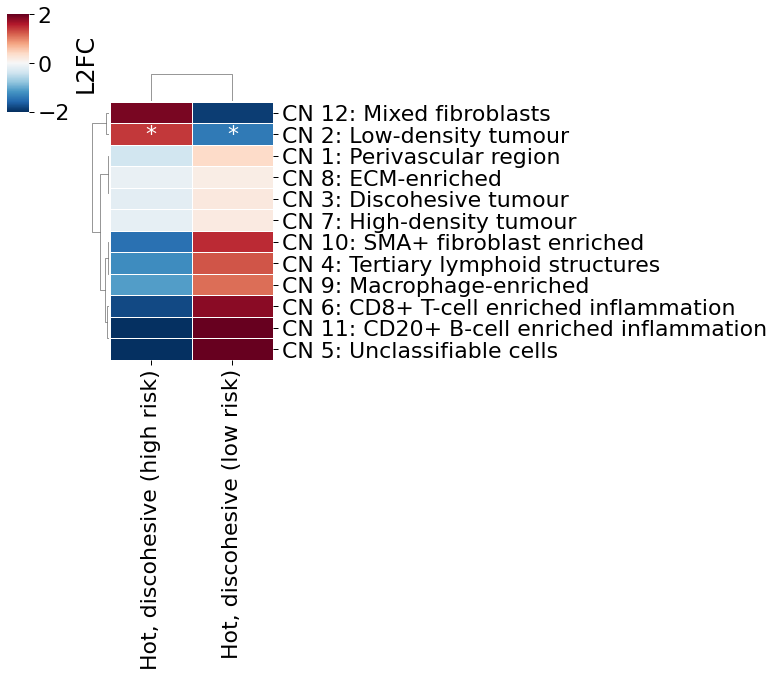

In [53]:
cn_prop_log_fc_df, annot_text = enrichment_test_by_phenotype_two_sample(data=cn_proportion_df_hd, phenotype_cols=[col for col in cn_frequency_df.columns if 'CN' in col], meta_col='cons_supercluster', p_th=0.05)
cn_prop_log_fc_df.columns.name = None
cn_prop_log_fc_df.index.name = None

# cn_prop_log_fc_df.columns = [
#     "CN 1: Low-density tumour",
#     "CN 2: Mixed lymphocytes",
#     "CN 3: DCN/COL1A enriched",
#     "CN 4: Unclassifiable cells",
#     "CN 5: Macrophage enriched",
#     "CN 6: Desmoplasia",
#     "CN 7: Tertiary lymphoid structures",
#     "CN 8: High-density tumour"
# ]

# cn_prop_log_fc_df.index = [
#     'Cold\ncohesive',
#     'Cold\ndiscohesive',
#     'Hot\ncohesive',
#     'Hot\ndiscohesive'

# ]

g = sns.clustermap(data=cn_prop_log_fc_df.T,
               cmap='RdBu_r',
               linewidth=.5,
               vmin=-2, vmax=2,
               annot=annot_text.T,
               fmt='',
               annot_kws={'fontsize':22},
               dendrogram_ratio=(.1, .1), 
               cbar_pos=(-0.08, 0.9, 0.03, 0.15), 
               cbar_kws={'label': 'L2FC'},
               figsize=(10.1,9))

plt.setp(g.ax_heatmap.xaxis.get_majorticklabels(), rotation=90);

# plt.savefig('/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/cell/plots/with_unclassifiable_cells/250314_cn_prop_enrichment_sc_disco.pdf', dpi=300, bbox_inches='tight', pad_inches=0.1)


### Neighbourhood maps

In [90]:
cn_proportion_df_[cn_proportion_df_['cons_supercluster'] == 'Hot, discohesive (high risk)']

CN 10: SMA+ fibroblast enriched  CN 11: B-cell enriched  \
7                           0.045839                0.000000   
23                          0.001202                0.000240   
34                          0.008912                0.080351   
41                          0.001635                0.000490   
42                          0.063955                0.000000   
155                         0.001131                0.002263   
176                         0.031752                0.017584   
183                         0.006634                0.008600   

     CN 12: Mixed fibroblasts  CN 1: Perivascular region  \
7                    0.464963                   0.012587   
23                   0.000000                   0.012740   
34                   0.000000                   0.020512   
41                   0.000000                   0.002288   
42                   0.000000                   0.010711   
155                  0.000000                   0.026589   
176                  0.000000                   0.051107   
183                  0.000000                   0.074324   

     CN 2: Low-density tumour  CN 3: Unclassifiable cells  \
7                    0.284050                    0.006575   
23                   0.709135                    0.013942   
34                   0.020229                    0.458481   
41                   0.483164                    0.338673   
42                   0.485563                    0.218410   
155                  0.678861                    0.055817   
176                  0.523846                    0.006199   
183                  0.364251                    0.252211   

     CN 4: Tertiary lymphoid structures  CN 5: Unclassifiable cells  \
7                              0.000000                    0.000000   
23                             0.000000                    0.000000   
34                             0.108785                    0.146555   
41                             0.000000                    0.006048   
42                             0.000000                    0.010866   
155                            0.000000                    0.000000   
176                            0.000127                    0.000506   
183                            0.000000                    0.046192   

     CN 6: CD8+ T-cell enriched  CN 7: High-density tumour  \
7                      0.000000                   0.017283   
23                     0.023077                   0.022356   
34                     0.059839                   0.001698   
41                     0.002942                   0.040209   
42                     0.000000                   0.104160   
155                    0.016594                   0.016594   
176                    0.001392                   0.029855   
183                    0.000614                   0.101966   

     CN 8: ECM enriched  CN 9: Macrophage enriched  core_ID      supercluster  \
7              0.168702                   0.000000  12-03-D  Hot, discohesive   
23             0.217308                   0.000000  12-09-E  Hot, discohesive   
34             0.093931                   0.000707  12-11-F  Hot, discohesive   
41             0.124551                   0.000000  12-14-C  Hot, discohesive   
42             0.106333                   0.000000  12-14-G  Hot, discohesive   
155            0.187252                   0.014897  22-03-D  Hot, discohesive   
176            0.197217                   0.140417  22-07-H  Hot, discohesive   
183            0.072850                   0.072359  22-10-F  Hot, discohesive   

    cluster             cons_supercluster  
7    HPC 13  Hot, discohesive (high risk)  
23   HPC 13  Hot, discohesive (high risk)  
34      NaN  Hot, discohesive (high risk)  
41   HPC 13  Hot, discohesive (high risk)  
42   HPC 13  Hot, discohesive (high risk)  
155  HPC 13  Hot, discohesive (high risk)  
176  HPC 13  Hot, discohesive (high risk)  
183  HPC 13  Hot, discohesive (high risk)

In [71]:
neighbourhood_df

index  Total_Cells  CD20+  Discohesive tumour  $DCN_{high}COL1A_{med}$  \
0         0            5      0                   0                        0   
1         1           10      0                   0                        0   
2         2            7      0                   0                        0   
3         3           11      0                   0                        0   
4         4            2      0                   0                        0   
...     ...          ...    ...                 ...                      ...   
4808   4808           13      1                   0                        0   
4809   4809           18      1                   1                        0   
4810   4810           15      1                   2                        0   
4811   4811           20      0                   0                        0   
4812   4812           17      0                   0                        0   

      Cohesive tumour  $S100A4_{high}FAP_{high}$  CD8+  \
0                   4                          0     0   
1                  10                          0     0   
2                   6                          0     0   
3                  10                          0     0   
4                   1                          0     0   
...               ...                        ...   ...   
4808                0                          0     0   
4809                0                          0     4   
4810                0                          0     3   
4811                0                          2     2   
4812                0                          0     0   

      $COL1A_{high}DCN_{med}$  CD68+  $SMA_{high}LIF_{high}$  \
0                           0      0                       0   
1                           0      0                       0   
2                           0      0                       0   
3                           0      0                       0   
4                           0      0                       0   
...                       ...    ...                     ...   
4808                        0      0                       0   
4809                        0      1                       0   
4810                        0      1                       0   
4811                        0      1                       0   
4812                        0      1                       0   

      $SMA_{med}COL1A_{med}$  CD4+  Endothelium  $PDPN_{high}$  \
0                          0     0            0              0   
1                          0     0            0              0   
2                          1     0            0              0   
3                          1     0            0              0   
4                          0     0            0              0   
...                      ...   ...          ...            ...   
4808                       0     0            1              0   
4809                       0     0            0              0   
4810                       0     0            0              0   
4811                       0     0            2              0   
4812                       0     0            0              0   

      Unclassifiable orig_idx   orig_phenotype     core  km_cluster  
0                  1   566379   Unclassifiable  12-02-A           7  
1                  0   566380  Cohesive tumour  12-02-A           1  
2                  0   566381  Cohesive tumour  12-02-A           1  
3                  0   566382  Cohesive tumour  12-02-A           1  
4                  1   566383   Unclassifiable  12-02-A           7  
...              ...      ...              ...      ...         ...  
4808              11  2660221            CD20+  22-15-I           2  
4809              11  2660222   Unclassifiable  22-15-I           2  
4810               8  2660223             CD8+  22-15-I           2  
4811              13  2660224   Unclassifiable  22-15-I           4  
4812            

In [110]:
cn_idx = neighbourhood_df.loc[(neighbourhood_df['core'].isin(['22-07-D', '21-05-G', '22-07-C', '21-02-C', '12-02-C', '13-02-A', '12-03-D', '12-09-E', '12-11-F', '12-14-C', '12-14-G', '22-03-D', '22-07-H', '22-10-F']))]['orig_idx'].values
cn_data = adata.obs.loc[cn_idx]
cn_data['CellY'] = cn_data['CellY'].apply(lambda x: x * -1)

cn_data['final_phenotype'].value_counts()

Tumour                       33112
Unclassifiable               16241
CD68+                         7617
CD20+                         7314
CD8+                          4684
$SMA_{med}COL1A_{med}$        3733
Endothelium                   3294
$S100A4_{high}FAP_{high}$     2566
$DCN_{high}COL1A_{med}$       1987
$SMA_{high}LIF_{high}$         927
CD4+                           675
$PDPN_{high}$                  170
$COL1A_{high}DCN_{med}$          1
Name: final_phenotype, dtype: int64

In [75]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon, Patch, Circle
import matplotlib.path as mpath

def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite Voronoi regions in a 2D diagram to finite regions.
    
    Parameters
    ----------
    vor : Voronoi
        Input Voronoi diagram from scipy.spatial.Voronoi.
    radius : float, optional
        Distance to 'close' the infinite regions.
        
    Returns
    -------
    regions : list of list of ints
        Indices of vertices in each revised Voronoi region.
    vertices : ndarray
        Coordinates for revised vertices.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")
    
    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2

    # Map each point to all ridges (edges) associated with it.
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct each region
    for p1, region_index in enumerate(vor.point_region):
        vertices = vor.regions[region_index]
        if all(v >= 0 for v in vertices):
            # Region is already finite.
            new_regions.append(vertices)
            continue

        # Otherwise, reconstruct the region.
        new_region = [v for v in vertices if v >= 0]
        for p2, v1, v2 in all_ridges[p1]:
            # Check if the ridge is incomplete
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0 and v2 >= 0:
                continue  # both vertices are finite
            # Compute the missing endpoint.
            t = vor.points[p2] - vor.points[p1]  # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())
        new_regions.append(new_region)

    return new_regions, np.asarray(new_vertices)

def clip_polygon_to_circle(polygon, center, radius):
    """
    Clip a polygon to a circle using the Sutherland-Hodgman algorithm.
    
    Parameters
    ----------
    polygon : ndarray
        Array of polygon vertices with shape (n, 2).
    center : tuple
        (x, y) coordinates of the circle center.
    radius : float
        Radius of the circle.
        
    Returns
    -------
    clipped_polygon : ndarray
        Array of clipped polygon vertices.
    """
    def is_inside(point):
        # Check if a point is inside the circle
        dx = point[0] - center[0]
        dy = point[1] - center[1]
        return dx*dx + dy*dy <= radius*radius
    
    def compute_intersection(p1, p2):
        # Find the intersection of a line segment with the circle
        dx = p2[0] - p1[0]
        dy = p2[1] - p1[1]
        a = dx*dx + dy*dy
        b = 2 * (dx * (p1[0] - center[0]) + dy * (p1[1] - center[1]))
        c = center[0]*center[0] + center[1]*center[1] + p1[0]*p1[0] + p1[1]*p1[1] - 2 * (center[0]*p1[0] + center[1]*p1[1]) - radius*radius
        
        discriminant = b*b - 4*a*c
        if discriminant < 0:
            # No intersection
            return None
        
        # Find the two intersection points
        t1 = (-b + np.sqrt(discriminant)) / (2*a)
        t2 = (-b - np.sqrt(discriminant)) / (2*a)
        
        # Choose the intersection point that lies on the segment p1-p2
        if 0 <= t1 <= 1:
            return [p1[0] + t1 * dx, p1[1] + t1 * dy]
        elif 0 <= t2 <= 1:
            return [p1[0] + t2 * dx, p1[1] + t2 * dy]
        else:
            return None
    
    output_polygon = polygon.copy()
    
    if len(output_polygon) < 3:
        return np.array([])
    
    # Loop through each edge of the polygon
    for i in range(len(output_polygon)):
        p1 = output_polygon[i-1]  # Previous point
        p2 = output_polygon[i]    # Current point
        
        inside_p1 = is_inside(p1)
        inside_p2 = is_inside(p2)
        
        # Both points inside: keep p2
        if inside_p1 and inside_p2:
            continue
        
        # p1 inside, p2 outside: add intersection
        elif inside_p1 and not inside_p2:
            intersection = compute_intersection(p1, p2)
            if intersection:
                output_polygon[i] = intersection
            else:
                # Fallback: project p2 to circle boundary
                vec = np.array([p2[0] - center[0], p2[1] - center[1]])
                norm = np.sqrt(np.sum(vec*vec))
                if norm > 0:
                    vec = vec / norm * radius
                    output_polygon[i] = [center[0] + vec[0], center[1] + vec[1]]
        
        # p1 outside, p2 inside: add intersection, then p2
        elif not inside_p1 and inside_p2:
            intersection = compute_intersection(p1, p2)
            if intersection:
                # Replace p1 with intersection
                output_polygon[i-1] = intersection
            else:
                # Fallback: project p1 to circle boundary
                vec = np.array([p1[0] - center[0], p1[1] - center[1]])
                norm = np.sqrt(np.sum(vec*vec))
                if norm > 0:
                    vec = vec / norm * radius
                    output_polygon[i-1] = [center[0] + vec[0], center[1] + vec[1]]
        
        # Both outside: depends on whether the edge crosses the circle
        else:
            # Compute the intersection(s)
            intersection = compute_intersection(p1, p2)
            if intersection:
                # The edge crosses the circle, keep the intersection
                output_polygon[i] = intersection
            else:
                # The edge doesn't cross the circle, skip this edge
                output_polygon[i-1] = None
                output_polygon[i] = None
    
    # Filter out None values
    filtered_polygon = [p for p in output_polygon if p is not None]
    
    if len(filtered_polygon) < 3:
        return np.array([])
    
    return np.array(filtered_polygon)

def plot_voronoi(cells, phenotypes, phenotype_colors, ax=None):
    """
    Generate a Voronoi plot of cell coordinates colored by phenotype,
    constrained to a circular boundary.
    
    Parameters
    ----------
    cells : ndarray
        A (N,2) array of cell coordinates.
    phenotypes : array-like
        A length-N array of phenotype labels.
    phenotype_colors : dict
        Mapping from phenotype labels to colors.
    ax : matplotlib.axes.Axes, optional
        An Axes instance to plot on.
        
    Returns
    -------
    ax : matplotlib.axes.Axes
        The axes with the plot.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Calculate center of the tissue (TMA core)
    center_x = np.mean(cells[:, 0])
    center_y = np.mean(cells[:, 1])
    center = (center_x, center_y)
    
    # Calculate radius based on distance from center to 95% of the cells
    distances = np.sqrt((cells[:, 0] - center_x)**2 + (cells[:, 1] - center_y)**2)
    radius = np.percentile(distances, 70)
    
    # No circular boundary drawn
    
    # Create Voronoi diagram
    vor = Voronoi(cells)
    regions, vertices = voronoi_finite_polygons_2d(vor)
    
    patches = []
    facecolors = []
    
    # Loop over each cell/region
    for i, region in enumerate(regions):
        # Skip cells outside the circle
        if np.sqrt((cells[i, 0] - center_x)**2 + (cells[i, 1] - center_y)**2) > radius:
            continue
            
        polygon = vertices[region]
        
        # Clip polygon to the circular boundary
        clipped_polygon = clip_polygon_to_circle(polygon, center, radius)
        
        if len(clipped_polygon) >= 3:  # Need at least 3 vertices to form a polygon
            patches.append(Polygon(clipped_polygon, closed=True))
            phenotype = phenotypes[i]
            facecolors.append(phenotype_colors.get(phenotype, 'gray'))
    
    if patches:
        patch_collection = PatchCollection(patches, facecolor=facecolors,
                                          edgecolor='k', alpha=0.5)
        ax.add_collection(patch_collection)
    
    # Only plot cells within the circle
    mask = distances <= radius
    ax.plot(cells[mask, 0], cells[mask, 1], 'ko', markersize=2)
    
    # Set plot limits exactly to the radius (no margin)
    ax.set_xlim(center_x - radius, center_x + radius)
    ax.set_ylim(center_y - radius, center_y + radius)
    
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal')
    ax.set_title(None)
    
    # Create legend
    legend_patches = []
    for phenotype, color in phenotype_colors.items():
        legend_patches.append(Patch(facecolor=color, edgecolor='k', label=phenotype, alpha=0.5))
    
    ax.legend(handles=legend_patches, title="Phenotypes", bbox_to_anchor=(1.05, 1), loc='upper left')
    
    return ax


In [163]:
cn_data_km = cn_data.reset_index().merge(neighbourhood_df[['orig_idx', 'km_cluster']], left_on='index', right_on='orig_idx')

# core = '21-05-G' # CC
core = '22-07-D' # CD
# core = '21-02-C' # HD
# core = '22-07-C' # HC
# core = '12-02-C' # HC
# core = '12-09-E' # HD hi
# core = '13-02-A' # HC

# for core in ['22-07-D', '21-05-G', '22-07-C', '21-02-C']:

# cn0_data['km_cluster'] = cn0_data['km_cluster'].astype(str)
palette = sns.color_palette("tab10", n_colors=len(cn_data_km['km_cluster'].unique()))
phenotype_cmap = dict(zip(cn_data_km['km_cluster'].unique(), palette))
phenotype_cmap

{1: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 7: (1.0, 0.4980392156862745, 0.054901960784313725),
 6: (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 0: (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 9: (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 8: (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 2: (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 5: (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 10: (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 11: (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 4: (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 3: (1.0, 0.4980392156862745, 0.054901960784313725)}

In [164]:
# Merge the unclassifiable colours

phenotype_cmap[4] = phenotype_cmap.get(2)
phenotype_cmap[3] = sns.color_palette("colorblind")[-2]

/tmp/ipykernel_152469/4122452925.py:30: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  handles = legend.legendHandles  # Get the line objects


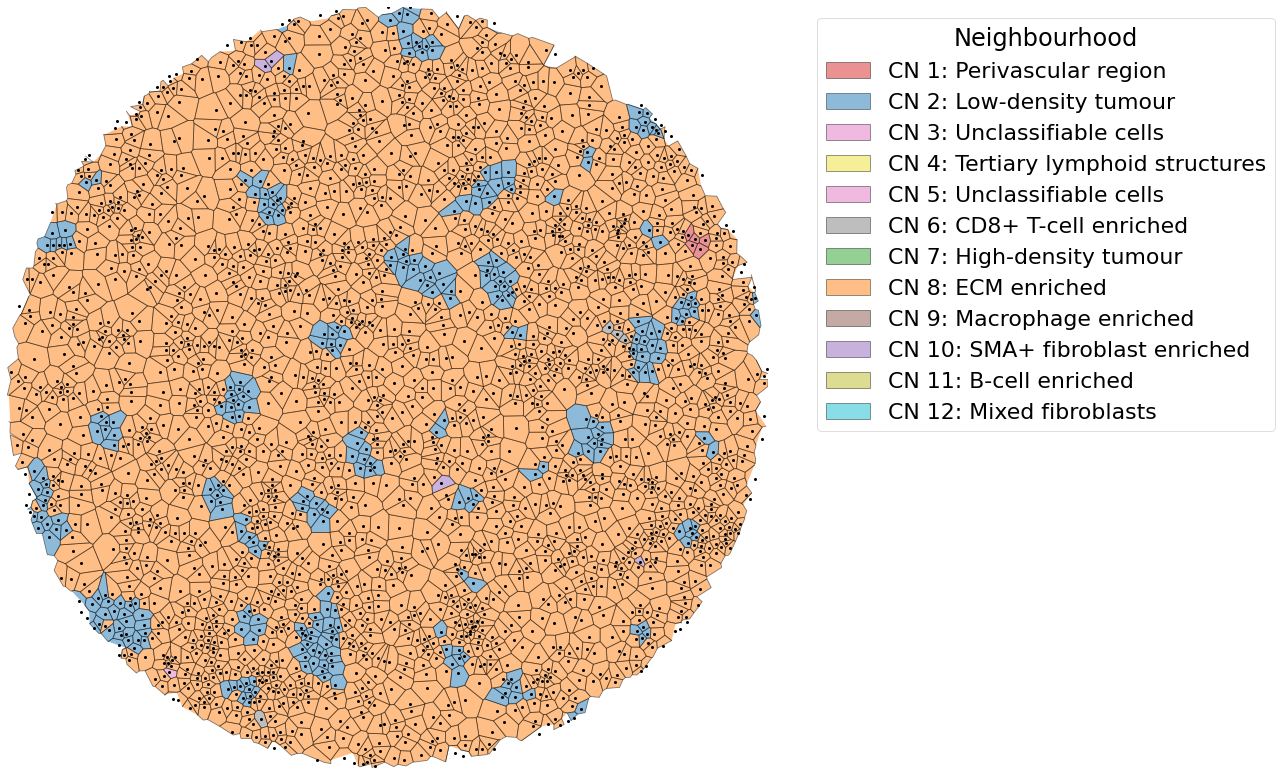

In [165]:
fig, ax = plt.subplots(figsize=(14, 14))

# plot_voronoi(
#     cells=cn_data_km.loc[(cn_data_km['core_ID'] == core) & (~cn_data_km['km_cluster'].isin([2,4]))][['CellX', 'CellY']].values, 
#     phenotypes=cn_data_km.loc[(cn_data_km['core_ID'] == core) & (~cn_data_km['km_cluster'].isin([2,4]))]['km_cluster'].values, 
#     phenotype_colors=phenotype_cmap, 
#     ax=ax
# )

plot_voronoi(
    cells=cn_data_km.loc[(cn_data_km['core_ID'] == core)][['CellX', 'CellY']].values, 
    phenotypes=cn_data_km.loc[(cn_data_km['core_ID'] == core)]['km_cluster'].values, 
    phenotype_colors=phenotype_cmap, 
    ax=ax
)

# ax.set_ylim([-25500, -25000])

# ax.get_legend().set_title('Neighbourhood')



# # new_order = [0, 4, 7, 5, 3, 1, 6, 2]  # New positions for elements
# new_order = sorted([int(handles[i].get_label()) for i in range(12)])
# reordered_handles = [handles[i] for i in new_order]
# labels = [h.get_label() for h in reordered_handles]


legend = ax.get_legend()
handles = legend.legendHandles  # Get the line objects
labels = [h.get_label() for h in handles]

# # Optionally, if your legend has an extra item (e.g., title entry), slice it:
# # handles, labels = handles[1:], labels[1:]

# # Zip, sort by converting the labels to integers, then unzip.
sorted_handles_labels = sorted(zip(labels, handles), key=lambda x: int(x[0]))
labels_sorted, handles_sorted = zip(*sorted_handles_labels)

# # Reassign the sorted legend to the plot.
# # ax.legend(handles_sorted, labels_sorted, title='Category')


labels = [
    "CN 1: Perivascular region",
    "CN 2: Low-density tumour",
    "CN 3: Unclassifiable cells" ,
    "CN 4: Tertiary lymphoid structures",
    "CN 5: Unclassifiable cells",
    "CN 6: CD8+ T-cell enriched ",
    "CN 7: High-density tumour",
    "CN 8: ECM enriched",
    "CN 9: Macrophage enriched",
    "CN 10: SMA+ fibroblast enriched",
    "CN 11: B-cell enriched",
    "CN 12: Mixed fibroblasts"
]

ax.legend(handles_sorted, labels, bbox_to_anchor=(1.05, 1), loc='upper left', title='Neighbourhood')
# ax.legend(handles_sorted, labels_sorted, bbox_to_anchor=(1.05, 1), loc='upper left', title='Neighbourhood')


# legend.remove()
ax.axis('off')

plt.savefig(f'/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/cell/neighbourhood_maps/250331_{core}_neighbourhoods_legend.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

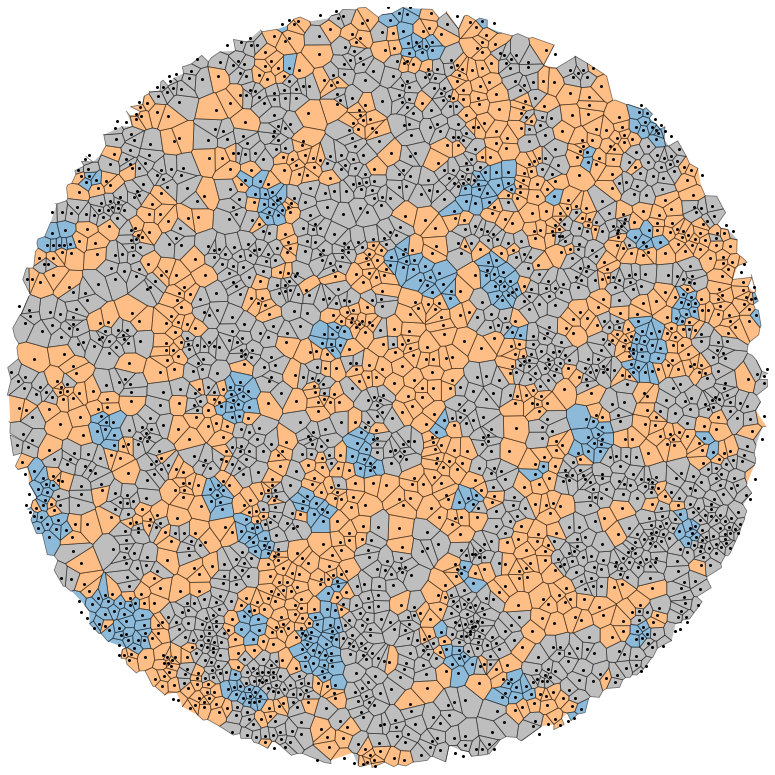

In [145]:
# core = '21-05-G' # CC
core = '22-07-D' # CD
# core = '21-02-C' # HD
# core = '22-07-C' # HC
# core = '12-02-C' # HC

# for core in ['22-07-D', '21-05-G', '22-07-C', '21-02-C']:

# cn0_data['km_cluster'] = cn0_data['km_cluster'].astype(str)
palette = sns.color_palette("tab10", n_colors=len(cn_data_km['km_cluster'].unique()))
phenotype_cmap = dict(zip(cn_data_km['km_cluster'].unique(), palette))

fig, ax = plt.subplots(figsize=(14, 14))

plot_voronoi(
    cells=cn_data_km[cn_data_km['core_ID'] == core][['CellX', 'CellY']].values, 
    phenotypes=cn_data_km[cn_data_km['core_ID'] == core]['km_cluster'].values, 
    phenotype_colors=phenotype_cmap, 
    ax=ax
)

ax.get_legend().remove()
ax.axis('off')

plt.savefig(f'/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/cell/neighbourhood_maps/disco_ver/{core}_neighbourhoods_legend.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

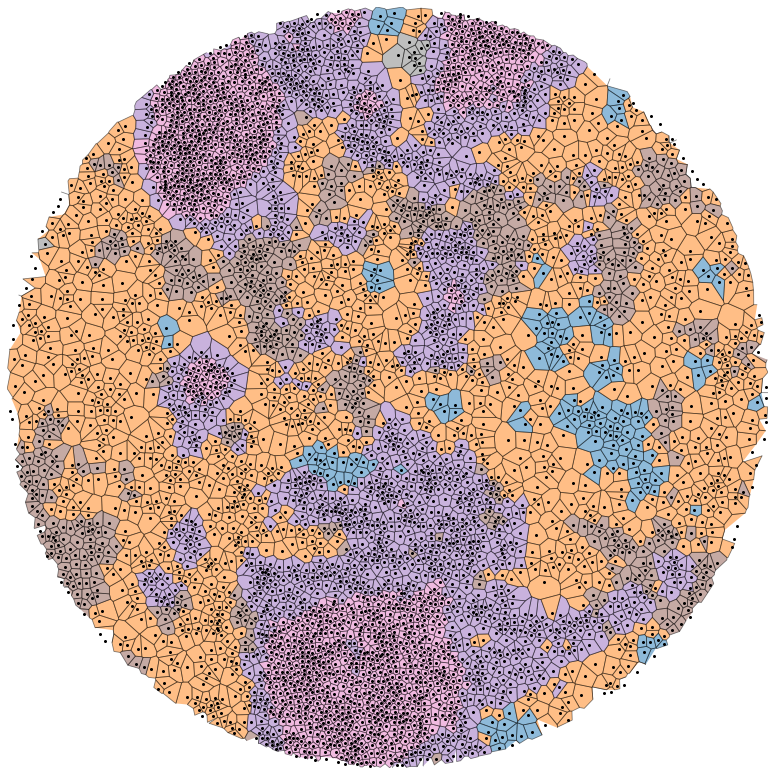

In [146]:
# core = '21-05-G' # CC
# core = '22-07-D' # CD
core = '21-02-C' # HD
# core = '22-07-C' # HC
# core = '12-02-C' # HC

# for core in ['22-07-D', '21-05-G', '22-07-C', '21-02-C']:

# cn0_data['km_cluster'] = cn0_data['km_cluster'].astype(str)
palette = sns.color_palette("tab10", n_colors=len(cn_data_km['km_cluster'].unique()))
phenotype_cmap = dict(zip(cn_data_km['km_cluster'].unique(), palette))

fig, ax = plt.subplots(figsize=(14, 14))

plot_voronoi(
    cells=cn_data_km[cn_data_km['core_ID'] == core][['CellX', 'CellY']].values, 
    phenotypes=cn_data_km[cn_data_km['core_ID'] == core]['km_cluster'].values, 
    phenotype_colors=phenotype_cmap, 
    ax=ax
)

ax.get_legend().remove()
ax.axis('off')

plt.savefig(f'/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/cell/neighbourhood_maps/disco_ver/{core}_neighbourhoods_legend.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)

In [147]:
# hc_cores = pure_clusters_frame[pure_clusters_frame['supercluster'] == 'Hot, cohesive']['core_ID'].values
# hc_cores = [hc for hc in hc_cores if hc in neighbourhood_df['core'].unique()]

# for core in hc_cores:
#     cn_idx = neighbourhood_df.loc[(neighbourhood_df['core'] == core)]['orig_idx'].values
#     cn_data = adata.obs.loc[cn_idx]
#     cn_data['CellY'] = cn_data['CellY'].apply(lambda x: x * -1)
#     cn_data_km = cn_data.reset_index().merge(neighbourhood_df[['orig_idx', 'km_cluster']], left_on='index', right_on='orig_idx')

#     palette = sns.color_palette("tab10", n_colors=len(cn_data_km['km_cluster'].unique()))
#     phenotype_cmap = dict(zip(cn_data_km['km_cluster'].unique(), palette))

#     fig, ax = plt.subplots(figsize=(14, 14))

#     plot_voronoi(
#         cells=cn_data_km[cn_data_km['core_ID'] == core][['CellX', 'CellY']].values, 
#         phenotypes=cn_data_km[cn_data_km['core_ID'] == core]['km_cluster'].values, 
#         phenotype_colors=phenotype_cmap, 
#         ax=ax
#     )

#     ax.get_legend().remove()
#     ax.axis('off')
    
#     plt.savefig(f'/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/cell/neighbourhood_maps/disco_ver/hc_{core}_neighbourhoods_legend.tiff', dpi=150, bbox_inches='tight', pad_inches=0.1)
#     plt.close()


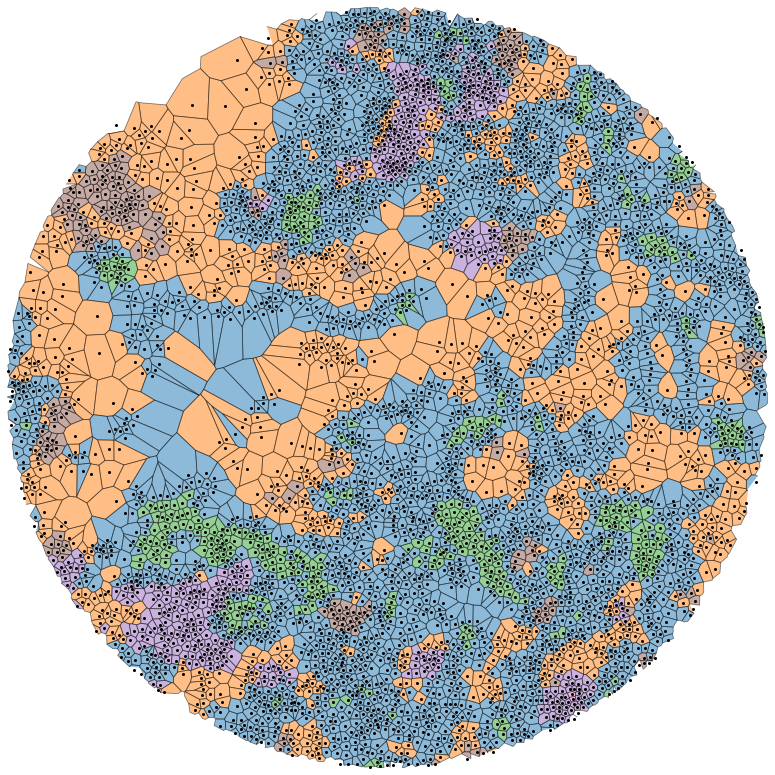

In [148]:
core = '13-02-A' # HC

# for core in ['22-07-D', '21-05-G', '22-07-C', '21-02-C']:

# cn0_data['km_cluster'] = cn0_data['km_cluster'].astype(str)
palette = sns.color_palette("tab10", n_colors=len(cn_data_km['km_cluster'].unique()))
phenotype_cmap = dict(zip(cn_data_km['km_cluster'].unique(), palette))

fig, ax = plt.subplots(figsize=(14, 14))

plot_voronoi(
    cells=cn_data_km[cn_data_km['core_ID'] == core][['CellX', 'CellY']].values, 
    phenotypes=cn_data_km[cn_data_km['core_ID'] == core]['km_cluster'].values, 
    phenotype_colors=phenotype_cmap, 
    ax=ax
)

ax.get_legend().remove()
ax.axis('off')

plt.savefig(f'/nfs/home/users/krakovic/sharedscratch/notebooks/latticea_he/final_figures/codex/neighbourhoods/cell/neighbourhood_maps/disco_ver/{core}_neighbourhoods_legend.tiff', dpi=300, bbox_inches='tight', pad_inches=0.1)